In [ ]:
# Data import
import os

# Checking whether the folder exists
if os.path.exists("/Users/knopka/Documents") :
    # Change the current working Directory    
    os.chdir("/Users/knopka/Documents")
else:
    print("Can't change the Current Working Directory")
    
    
print("Current Working Directory " , os.getcwd())

import pandas as pd
start = pd.read_excel(r'/Users/knopka/Documents/SEM_campaign.xlsx')

# Exploratory Data Analysis

In [ ]:
# packages import

import numpy as np
import copy

start.info()

- no missing values
- data types look good for further analysis

In [663]:
# we need only Search Network and enabled campaigns - removing unnecessary rows

start = start[start['Network'] == 'Search Network']
start = start[start['Campaign_state'] == 'enabled']
start = start.drop(columns=['Network', 'Campaign_state'])

Noted that one campaign can have several rows for the same day in the initial dataset.
Therefore, grouping the values so each Campaign has only one row per each day and cumulated Cost for this whole day

In [ ]:
sem = start.groupby(['Campaign', 'Day'])['Cost'].sum().reset_index()

In [ ]:
sem.describe(include = 'all')

## Data visualisation

In [666]:
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as pyplt
%matplotlib inline

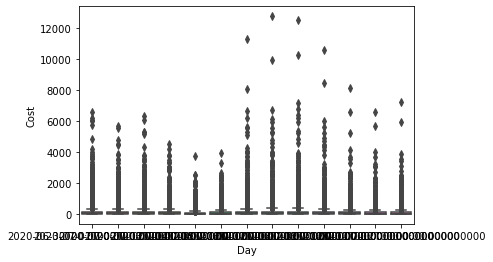

In [667]:
sns.boxplot (x = 'Day', y = 'Cost', data = sem)

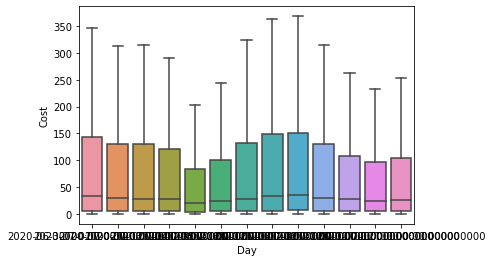

In [668]:
sns.boxplot (x = 'Day', y = 'Cost', data = sem, showfliers = False)

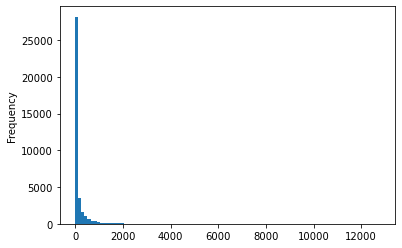

In [669]:
sem['Cost'].plot.hist(bins=100)

There are a lot of outliers in the initial data, what means that there a lot of high costs, however the mean is still not visible.

Further investigation is needed in order to understand the anomalies.

The majority of the Costs is between 0 and 2000.

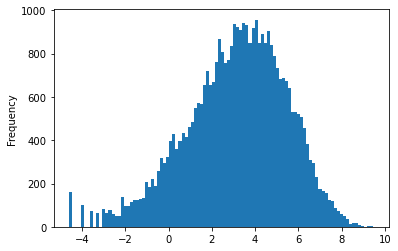

In [670]:
np.log(sem['Cost']).plot.hist(bins=100)

After taking the logarithm of the 'Cost' we assume that the distribution is close to normal and in the further analysis normal distribution will be taken into consideration and 'Cost' value will be treated as the value with normal distribution

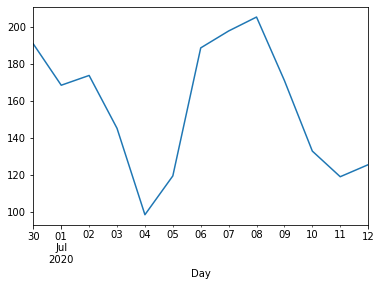

In [671]:
sem.groupby('Day')['Cost'].mean().plot()

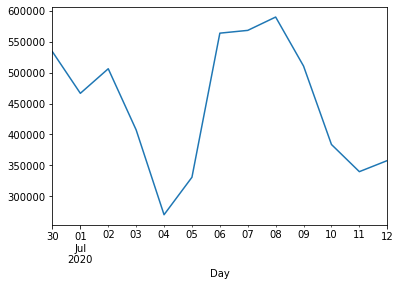

In [672]:
sem.groupby('Day')['Cost'].sum().plot()

Plots of the 'Cost' by 'Day' show some seasonal trends: we see that on weekends (especially on Saturdays) the cost is decreasing, in the middle of the week (Wednesday - Friday) it is the highest.

## Adding columns

In [673]:
#adding log variable 'Cost' to the dataset

sem['cost_log'] = np.log(sem['Cost'])

In order to extract some additional information form the existing dataset we can create new values:

* the name of the day of the week
* one day ago as a date in order to create the value of the Cost from the previous day
* whether the day was a weekend or not
* labels for the Campaign ID

In [674]:
# Creating the feature of the previous day

from datetime import datetime, timedelta

sem['day_ago'] = sem['Day']-timedelta(days=1)

In [675]:
# Creating the name of the day

sem['day_name'] = sem['Day'].dt.strftime("%a")

In [676]:
# Creating the value which returns 1 if it is Saturday or Sunday and 0 for the rest

sem['weekend'] = sem['day_name'].apply(lambda x: x in ['Sat','Sun']).astype(int)

There are a lot of unique values for Campaign ID - it will be difficult to use this value for the prediction.

Campaign IDs should be clustered. For this K-Means unsupervised learning will be used

In [677]:
# Aggregating Campaign IDs

sem_aggr = sem.groupby('Campaign')['Cost'].agg(['mean', 'std', 'var', 'min', 'max', 'median', 'count'])

In [678]:
sem_aggr

,mean,std,var,min,max,median,count
Campaign,,,,,,,
-9.218312e+18,256.462308,108.449886,11761.377686,129.09,424.91,250.590,13
-9.210789e+18,0.240000,0.303842,0.092320,0.03,0.82,0.105,6
-9.206652e+18,95.253846,47.725704,2277.742776,18.75,167.68,112.020,13
-9.204469e+18,1.682500,2.145979,4.605225,0.04,4.66,1.015,4
-9.203933e+18,21.468462,6.816587,46.465864,15.06,41.20,19.700,13
...,...,...,...,...,...,...,...
9.196946e+18,1136.395385,568.237475,322893.828310,335.06,2173.93,991.880,13
9.198218e+18,1.320000,NaN,NaN,1.32,1.32,1.320,1
9.198927e+18,257.235000,7.346839,53.976050,252.04,262.43,257.235,2


There are missing values in columns 'std' and 'var' what makes total sense as there are campaigns with only one entry.

'std' and 'var' will not be used in the final DataFrame for clustering

In [679]:
# removing 'std' and 'var' from the Cost aggregation dataset

sem_aggr = sem.groupby('Campaign')['Cost'].agg(['mean', 'min', 'max', 'median', 'count'])
sem_aggr

,mean,min,max,median,count
Campaign,,,,,
-9.218312e+18,256.462308,129.09,424.91,250.590,13
-9.210789e+18,0.240000,0.03,0.82,0.105,6
-9.206652e+18,95.253846,18.75,167.68,112.020,13
-9.204469e+18,1.682500,0.04,4.66,1.015,4
-9.203933e+18,21.468462,15.06,41.20,19.700,13
...,...,...,...,...,...
9.196946e+18,1136.395385,335.06,2173.93,991.880,13
9.198218e+18,1.320000,1.32,1.32,1.320,1
9.198927e+18,257.235000,252.04,262.43,257.235,2


The assumed categories for clustering Campaign IDs into categories can be 'cheap', 'medium' and 'expensive' (the hypothesis is that there will be 3 categories).

First the optimal number of cluster should be checked (it was assumed that it can be 3 clusters).

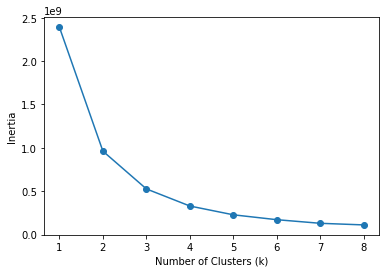

In [680]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

num_clusters = [x for x in range(1,9)]
inertias = []

for k in num_clusters:
  model = KMeans(n_clusters = k)
  model.fit(sem_aggr)
  inertias.append(model.inertia_)

plt.plot(num_clusters, inertias, '-o')

plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')

plt.show()

It looks that 3 or 4 categories are good for K-Means model. Let's use 3 categories

In [681]:
# Clustering and categorizing Campaign IDs with n_clusters = 3

model_clustering = KMeans(n_clusters = 3)

model_clustering.fit(sem_aggr)

labels = model_clustering.predict(sem_aggr)

In [ ]:
sem_aggr['label'] = labels

In [684]:
# Checking how the model labelled Campaigns and how many of each category we have

labels_count = sem_aggr['label'].value_counts()

labels_count

0    3152
2     242
1      30
Name: label, dtype: int64

In [685]:
sem_aggr.groupby('label').mean()

,mean,min,max,median,count
label,,,,,
0,55.626206,26.799905,91.542960,55.491609,10.667830
1,3086.595872,1404.267333,4920.045000,3246.484000,13.000000
2,801.091219,422.500579,1232.952397,819.045537,12.661157


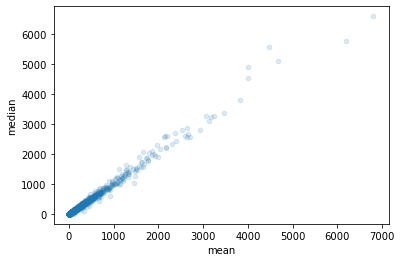

In [686]:
sem_aggr.plot.scatter(x='mean',y='median', alpha=0.15)

The model categorized Campaigns in 3 clusters - 0 cluster is the biggest one and represents the cheapest campaigns.

Aggregated values for 3 categories look good, therefore the clustering can be used for further analysis.

In [ ]:
# Adding labels for each Campaign according to the above clustering to the main DataFrame

sem_merged = pd.merge(sem, sem_aggr['label'], how = 'left', on = 'Campaign')

In [ ]:
sem_merged.groupby('label')['Cost'].agg(['mean', 'std', 'min', 'max'])

# Defining outliers

For defining outliers Three-Sigma Rule will be used

In [689]:
# Creating the DataFrame for aggregated values of 3 categories and calculating 3 Sigmas down and up in order to identify 99.7% of the values
# and show outliers 

for_outliers = sem_merged.groupby('label')['cost_log'].agg(['mean', 'std', 'min', 'max'])
for_outliers['min_border'] = for_outliers['mean'] - 3*for_outliers['std']
for_outliers['max_border'] = for_outliers['mean'] + 3*for_outliers['std']

for_outliers

,mean,std,min,max,min_border,max_border
label,,,,,,
0,2.758375,2.114497,-4.605170,6.850793,-3.585116,9.101865
1,7.883983,0.564732,5.702815,9.454993,6.189787,9.578180
2,6.511462,0.630438,0.858662,8.134318,4.620149,8.402775


In [ ]:
# Adding the table with outliers to our main DataFrame using labels as a joiner

sem_with_labels = sem_merged.merge(for_outliers,on=['label'])

In [ ]:
# Creating a new column 'normal' which will show whether the value is an outlier ('False' value) or not ('True' value)

sem_with_labels['normal'] = (sem_with_labels['min_border']<= sem_with_labels['cost_log'])& (sem_with_labels['cost_log']<=sem_with_labels['max_border'])

# Building the prediction model

## Preparing the dataset

In [ ]:

sem_with_labels['day_name'] = sem_with_labels['day_name'].astype('category')

sem_with_labels['day_name_lbl'] = sem_with_labels['day_name'].cat.codes


In [693]:
# In order to add the column with the Cost value of the previous day we will use self join and 'day_ago' column

# First we have to create a column by which we will self join the DataFrame - it will be the concatenation of the columns 'Campaign', 'Day'
# and 'day_ago'

sem_with_labels['conc'] = sem_with_labels['Campaign'].map(str) + '_' + sem_with_labels['Day'].map(str)

sem_with_labels['conc_ago'] = sem_with_labels['Campaign'].map(str) + '_' + sem_with_labels['day_ago'].map(str)

In [694]:
# Creating the DataFrame for the faster merge - it is just a subset with chosen columns from our main DataFrame

d1 = sem_with_labels[['conc', 'Cost', 'cost_log']]

In [ ]:
# Merging the DataFrames

big_merge = sem_with_labels.merge(right=d1, how = 'left', left_on='conc_ago', right_on='conc')

The new dataframe has missing values as the first day of our dataset (30-06-2020) does not have the values from the previous day.

The entries with missing values will be deleted from the dataset.

In [696]:
big_merge_without_na = big_merge.dropna().reset_index()

The final step in data preparation will be clearing the dataset from unnecessary columns and renaming these columns.

Two separate dataframes will be created as we want to have two prediction models - one with Cost values and one with logarithmic Cost values.

In [697]:
# 1. Choosing the necessary columns from the big dataset created

sem_new = big_merge_without_na[['label', 'day_name_lbl', 'weekend', 'Cost_x', 'Cost_y']]

sem_new_log = big_merge_without_na[['label', 'day_name_lbl', 'weekend', 'cost_log_x', 'cost_log_y']]

# 2. Renaming the columns for better and clearer view - these datasets will be used for predictions

sem_final = sem_new.rename(columns={"label": "campaign_label", "Cost_x": "Cost", "Cost_y": "cost_ago"})

sem_final_log = sem_new_log.rename(columns={"label": "campaign_label", "cost_log_x": "cost_log", "cost_log_y": "cost_log_ago"})


## Preparing values

In [698]:
# Splitting the data by dependent and independent values

y = sem_final['Cost']

y_log = sem_final_log['cost_log']

x = sem_final.drop('Cost', axis = 1)

x_log = sem_final_log.drop('cost_log', axis = 1)


# Splitting the data to train and test sets

from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

x_log_train, x_log_test, y_log_train, y_log_test = train_test_split(x_log, y_log, train_size=0.8, test_size=0.2)

## Creating Random Forests for normal values

In [707]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators = 2000, max_depth = 5, random_state = 0)

model.fit(x_train, y_train)

y_predict = model.predict(x_test)

In [708]:
from sklearn.metrics import r2_score

print('Score for normal values:', r2_score(y_test, y_predict))

Score for normal values: 0.9161271590545641


## Creating Random Forests for logarithmic values

In [709]:
from sklearn.ensemble import RandomForestRegressor

model_log = RandomForestRegressor(n_estimators = 300, max_depth = 5, random_state = 0)

model_log.fit(x_log_train, y_log_train)

y_log_predict = model_log.predict(x_log_test)

# As the value was a logarithmic value for the final prediction of the Cost exp should be taken from the predicted value

y_log_final_predict = [round(np.exp(z),2) for z in y_log_predict]

In [710]:
print('Score for logarithmic values:', r2_score(y_log_test, y_log_predict))

Score for logarithmic values: 0.8874009112125674


## Final decision

After evaluating two models we can see that the score is higher for the model using normal values - this model will be our final choice. 

P.S.: in the final model feature 'weekend' was added. Before that stronger was logarithmic method, however the difference in R^2 score was smaller than it is now.

# Predicting new values

Requirements to the data downloaded:
    
* .xlsx format
* there should be at least 5 observations of the previous days for the Campaign
* there should be three columns in the data: 'Campaign', 'Day', 'Cost'
* there should be one row per Campaign per Day

The code below repeats main lines from the code above. It is explained by the fact that we get not so much information about the Campaign and have to create a lot of new values for the analysis.

In [711]:
# Importing new set of data


import os

# Checking whether the folder exists
if os.path.exists("/Users/knopka/Documents") :
    # Changing the current working Directory. Please put here the directoryy where the file is
    os.chdir("/Users/knopka/Documents")
else:
    print("Can't change the Current Working Directory")
    
    
print("Current Working Directory " , os.getcwd())

import pandas as pd
start = pd.read_excel(r'/Users/knopka/Documents/SEM_campaign_new.xlsx')

Current Working Directory  /Users/knopka/Documents


In [712]:
# Assigning the appropriate label to the Campaign using the results from K-Mean clustering

new_aggr = start['Cost'].agg(['mean', 'min', 'max', 'median', 'count'])

new_list = new_aggr.values

new_list

new_array = new_list.reshape(1, -1)

label = model_clustering.predict(new_array)

In [713]:
# Adding new values to the dataset

start['day_ago'] = start['Day']-timedelta(days=1)      # the previous day

start['day_name'] = start['Day'].dt.strftime("%a")     # name of the day

start['weekend'] = start['day_name'].apply(lambda x: x in ['Sat','Sun']).astype(int)     # whether the day is a weekend

start['campaign_label'] = label.tolist()[0]            # Adding new predicted label as a separate column (for one Campaign the value will be the same)

start['conc'] = start['Campaign'].map(str) + '_' + start['Day'].map(str)                # Concatenated values for further self merge

start['conc_ago'] = start['Campaign'].map(str) + '_' + start['day_ago'].map(str)

start['day_name'] = start['day_name'].astype('category')                                # Labeling the days of the week

start['day_name_lbl'] = start['day_name'].cat.codes

In [715]:
# Creating the dataset for the merge

d1 = start[['conc', 'Cost']]

In [716]:
# Merging datasets in order to have the Column with the cost of the previous day

merged = start.merge(right=d1, how = 'left', left_on='conc_ago', right_on='conc')

In [ ]:
# Creating final set (removing cost column as this will be the value we want to predict)

start_new = merged[['campaign_label', 'day_name_lbl', 'weekend', 'Cost_y']]

start_new = start_new.rename(columns={"Cost_y": "cost_ago"})

In [733]:
row_index = len(start_new) - 1

new_test = start_new.loc[row_index, : ]

new_row = new_test.values

new_array_row = new_row.reshape(1, -1)

In [738]:
y_predict = model.predict(new_array_row)

y_predict

array([118.3040831])